### A/334 Parameter Specification
- Autocorrection Delay = 3ms
- Sysmbol interval T = 1/106 seconds
- Marking Frequency Band = 2.5kHz - 5.0kHz

### Sample 
- frequency 48kHz -> 48000 frames/second
- Symbol frames 48000/106 = ca. 453 frames

### Help


In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.signal import butter, lfilter
from pydub import AudioSegment
from scipy import signal

In [2]:
audioSegment = AudioSegment.from_file("video.ts")
sig = np.frombuffer(audioSegment.raw_data, dtype='<i4').reshape(-1, audioSegment.channels)
samplerate = audioSegment.frame_rate

In [3]:
offset_sec = 0.003
offset_frames = int(samplerate * offset_sec)
symbols_per_sec = 106
samples_per_symbol = samplerate / symbols_per_sec
samples_per_symbol

452.8301886792453

In [4]:
#https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
sig_bandpassed = butter_bandpass_filter(sig[:, 0], 2500, 5000, samplerate)

C:\Users\Janbe\AppData\Local\pypoetry\Cache\virtualenvs\video-watermark-decoder-evsskYxq-py3.10\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


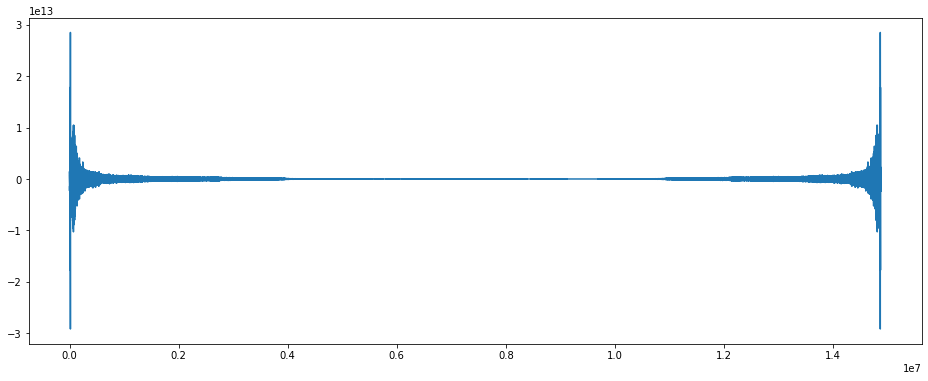

In [6]:
sig_fft = np.fft.fft(sig[:, 0])

plt.figure(figsize=(16, 6))
plt.plot(sig_fft)

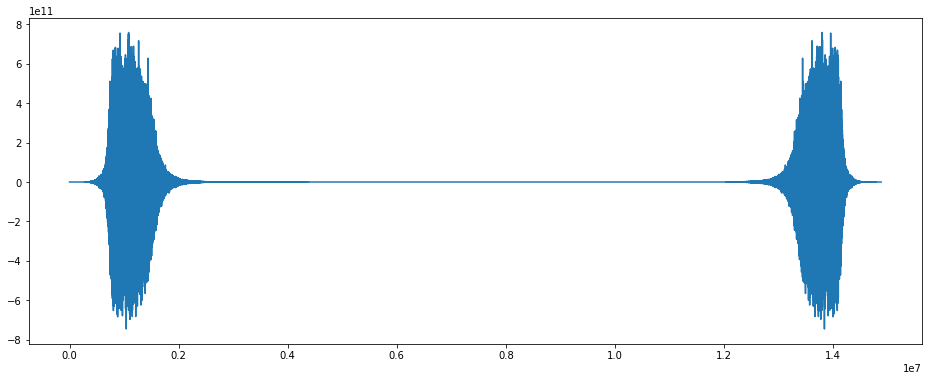

In [7]:
sig_fft = np.fft.fft(sig_bandpassed)

plt.figure(figsize=(16, 6))
plt.plot(sig_fft)

should be 4416.666666666667 symbols


C:\Users\Janbe\AppData\Local\Temp\ipykernel_19304\2835689224.py:14: RuntimeWarning: divide by zero encountered in log10
  diffs_fast = np.log10(np.abs(diffs_fast)) * diffs_fast / np.abs(diffs_fast)
C:\Users\Janbe\AppData\Local\Temp\ipykernel_19304\2835689224.py:14: RuntimeWarning: invalid value encountered in multiply
  diffs_fast = np.log10(np.abs(diffs_fast)) * diffs_fast / np.abs(diffs_fast)


Time to run: 9.07 seconds


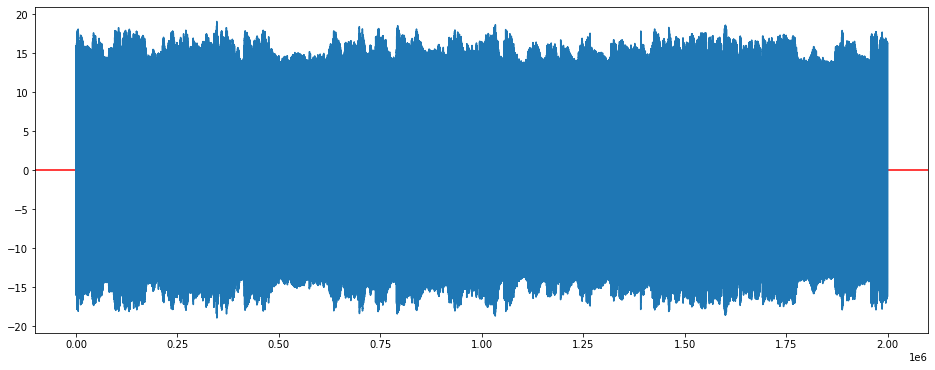

In [16]:
start_time = time.time()
samples_fast = 2000000
print(f"should be {symbols_per_sec * samples_fast / samplerate} symbols")
sigg = sig_bandpassed
diffs_fast = np.zeros(samples_fast)
for i in range(int(samples_per_symbol/2), samples_fast):
    # TODO get rid of range and maybe average it
    first_half_acf = np.correlate(sigg[i:int(samples_per_symbol/2)+i], sigg[i-offset_frames:int(samples_per_symbol/2)+i-offset_frames])
    second_half_acf = np.correlate(sigg[i+int(samples_per_symbol/2):i+int(samples_per_symbol)], sigg[i+int(samples_per_symbol/2)-offset_frames:i+int(samples_per_symbol)-offset_frames])
    diffs_fast[i] = first_half_acf[0] - second_half_acf[0]
    
#diffs_fast = np.maximum(-1, diffs_fast)
#diffs_fast = np.minimum(1, diffs_fast)
diffs_fast = np.log10(np.abs(diffs_fast)) * diffs_fast / np.abs(diffs_fast)

plt.figure(figsize=(16, 6))
plt.vlines(np.arange(0,samples_fast, samples_per_symbol), -0.5, 0.5, colors=["red"])
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(diffs_fast, '-')
print(f"Time to run: {(time.time() - start_time):.2f} seconds")

Time to run: 1.20 seconds


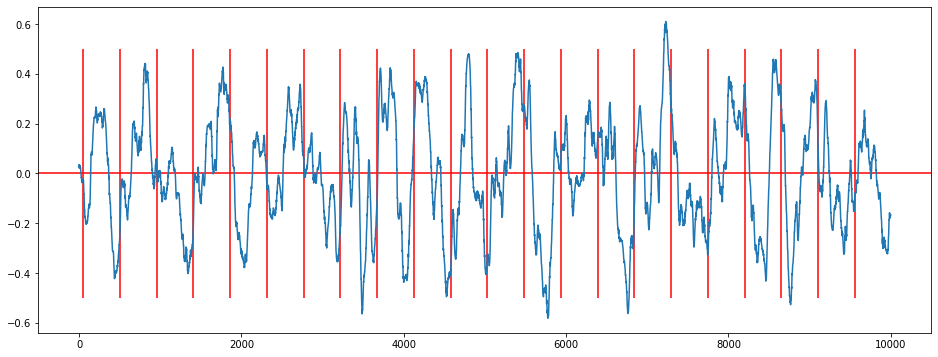

In [9]:
start_time = time.time()
samples = 10000
sigg = sig_bandpassed
diffs = np.zeros(samples)
for i in range(samples):
    # TODO get rid of range and maybe average it
    orig_acf = acf(sigg[i:int(samples_per_symbol/2)+i], nlags=offset_frames)
    delay_acf = acf(sigg[i+int(samples_per_symbol/2):i+int(samples_per_symbol)], nlags=offset_frames)
    diffs[i] = orig_acf[-1] - delay_acf[-1]

plt.figure(figsize=(16, 6))
plt.vlines(np.arange(50,samples, samples_per_symbol), -0.5, 0.5, colors=["red"])
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(diffs, '-')
print(f"Time to run: {(time.time() - start_time):.2f} seconds")

In [13]:
MESSAGE_HEADER = '10101110000010101011100111100100'
for i in range(samples-5000):
    is_correct = True
    for j in range(len(MESSAGE_HEADER)):
        if not (diffs[int(j*samples_per_symbol+i)] >= 0 and MESSAGE_HEADER[j] == '1' or diffs[int(j*samples_per_symbol+i)] < 0 and MESSAGE_HEADER[j] == '0'):
            is_correct = False
            break
    if is_correct:
        print(f"found offset for message start {i}")

In [17]:
MESSAGE_HEADER = '10101110000010101011100111100100'
for i in range(samples_fast-5000):
    is_correct = True
    for j in range(len(MESSAGE_HEADER)):
        if not (diffs_fast[int(j*samples_per_symbol+i)] >= 0 and MESSAGE_HEADER[j] == '1' or diffs_fast[int(j*samples_per_symbol+i)] < 0 and MESSAGE_HEADER[j] == '0'):
            is_correct = False
            break
    if is_correct:
        print(f"found offset for message start {i}")

found offset for message start 71984
found offset for message start 71985
found offset for message start 71986
found offset for message start 71987
found offset for message start 71988
found offset for message start 71989
found offset for message start 71990
found offset for message start 71991
found offset for message start 71992
found offset for message start 71993
found offset for message start 71994
found offset for message start 71995
found offset for message start 71996
found offset for message start 71997
found offset for message start 71998
found offset for message start 71999
found offset for message start 72000
found offset for message start 72001
found offset for message start 72002
found offset for message start 72003
found offset for message start 72004
found offset for message start 72005
found offset for message start 72006
found offset for message start 72007
found offset for message start 72008
found offset for message start 72009
found offset for message start 72010
f

found offset for message start 431994
found offset for message start 431995
found offset for message start 431996
found offset for message start 431997
found offset for message start 431998
found offset for message start 431999
found offset for message start 432000
found offset for message start 432001
found offset for message start 432002
found offset for message start 432003
found offset for message start 432004
found offset for message start 432005
found offset for message start 432006
found offset for message start 432007
found offset for message start 432008
found offset for message start 432009
found offset for message start 432010
found offset for message start 432011
found offset for message start 432012
found offset for message start 432013
found offset for message start 432014
found offset for message start 432015
found offset for message start 432016
found offset for message start 432017
found offset for message start 432018
found offset for message start 432019
found offset

found offset for message start 791995
found offset for message start 791996
found offset for message start 791997
found offset for message start 791998
found offset for message start 791999
found offset for message start 792000
found offset for message start 792001
found offset for message start 792002
found offset for message start 792003
found offset for message start 792004
found offset for message start 792005
found offset for message start 792006
found offset for message start 792007
found offset for message start 792008
found offset for message start 792009
found offset for message start 792010
found offset for message start 792011
found offset for message start 792012
found offset for message start 792013
found offset for message start 792014
found offset for message start 792015
found offset for message start 792016
found offset for message start 792017
found offset for message start 792018
found offset for message start 792019
found offset for message start 792020
found offset

found offset for message start 1151994
found offset for message start 1151995
found offset for message start 1151996
found offset for message start 1152000
found offset for message start 1152001
found offset for message start 1152002
found offset for message start 1152003
found offset for message start 1152004
found offset for message start 1152005
found offset for message start 1152006
found offset for message start 1152007
found offset for message start 1152008
found offset for message start 1152009
found offset for message start 1152010
found offset for message start 1152011
found offset for message start 1152012
found offset for message start 1152013
found offset for message start 1152014
found offset for message start 1152015
found offset for message start 1152016
found offset for message start 1152017
found offset for message start 1152018
found offset for message start 1152019
found offset for message start 1152020
found offset for message start 1152021
found offset for message 

found offset for message start 1511984
found offset for message start 1511985
found offset for message start 1511986
found offset for message start 1511987
found offset for message start 1511988
found offset for message start 1511989
found offset for message start 1511990
found offset for message start 1511991
found offset for message start 1511992
found offset for message start 1511993
found offset for message start 1511994
found offset for message start 1511995
found offset for message start 1511996
found offset for message start 1511997
found offset for message start 1511998
found offset for message start 1511999
found offset for message start 1512000
found offset for message start 1512001
found offset for message start 1512002
found offset for message start 1512003
found offset for message start 1512004
found offset for message start 1512005
found offset for message start 1512006
found offset for message start 1512007
found offset for message start 1512008
found offset for message 

found offset for message start 1799969
found offset for message start 1799970
found offset for message start 1799971
found offset for message start 1799972
found offset for message start 1799973
found offset for message start 1799974
found offset for message start 1799975
found offset for message start 1799976
found offset for message start 1799977
found offset for message start 1799978
found offset for message start 1799979
found offset for message start 1799980
found offset for message start 1799981
found offset for message start 1799982
found offset for message start 1799983
found offset for message start 1799984
found offset for message start 1799985
found offset for message start 1799986
found offset for message start 1799987
found offset for message start 1799988
found offset for message start 1799989
found offset for message start 1799990
found offset for message start 1799991
found offset for message start 1799992
found offset for message start 1799993
found offset for message 